# Курсовой проект


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit import als

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

from scipy.sparse import csr_matrix, coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

/Users/ekaterinarazdumina/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv('./retail_train.csv')
item_features = pd.read_csv('./product.csv')
user_features = pd.read_csv('./hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

1. Исследование данных

In [3]:
# Сначала посмотрим таблицу user_features
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [4]:
user_features.head(10)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
5,65+,B,Under 15K,Homeowner,2 Adults No Kids,2,None/Unknown,17
6,45-54,A,100-124K,Homeowner,2 Adults No Kids,2,None/Unknown,18
7,35-44,B,15-24K,Unknown,Single Female,1,None/Unknown,19
8,25-34,A,75-99K,Renter,2 Adults No Kids,2,None/Unknown,20
9,45-54,A,75-99K,Homeowner,2 Adults No Kids,2,None/Unknown,22


In [5]:
# Практически все признаки категориальные (с данными будут лучше работать бустинги типа lgbm и cat boost'а). 
# Попробуем разложить признаки и посмотреть на их корреляцию

In [6]:
user_features_dum = pd.get_dummies(user_features) 
user_features_dum.describe()

,user_id,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,1235.176030,0.057428,0.177278,0.242197,0.359551,0.073658,0.089888,0.424469,0.146067,0.429463,...,0.091136,0.318352,0.397004,0.136080,0.066167,0.082397,0.142322,0.074906,0.086142,0.696629
std,736.804647,0.232804,0.382143,0.428681,0.480169,0.261377,0.286199,0.494571,0.353394,0.495309,...,0.287982,0.466128,0.489582,0.343088,0.248730,0.275140,0.349598,0.263405,0.280749,0.460001
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,596.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1218.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1914.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2499.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
user_features_dum.corr()
# Между некоторыми признаками есть достаточно высокая корреляция

,user_id,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,1.000000,0.023486,0.019316,-0.009471,-0.001246,-0.007720,-0.021569,0.001452,0.007851,-0.007051,...,0.008313,0.055111,-0.028422,0.006670,-0.074600,0.016330,-0.010482,-0.069963,0.012320,0.040509
age_desc_19-24,0.023486,1.000000,-0.114579,-0.139544,-0.184945,-0.069603,-0.077573,-0.114271,0.049848,0.078535,...,-0.040874,0.050174,-0.013842,0.011586,-0.022530,-0.054451,0.037677,-0.049854,-0.037534,0.022820
age_desc_25-34,0.019316,-0.114579,1.000000,-0.262427,-0.347808,-0.130896,-0.145883,-0.054728,0.048672,0.019919,...,-0.112918,-0.029515,-0.082677,0.063656,0.060550,0.063005,0.044820,0.116276,0.055550,-0.134548
age_desc_35-44,-0.009471,-0.139544,-0.262427,1.000000,-0.423588,-0.159416,-0.177668,0.080496,0.021972,-0.096053,...,-0.047391,-0.042290,-0.077539,0.047599,0.048810,0.106138,0.044953,0.038393,0.106857,-0.121366
age_desc_45-54,-0.001246,-0.184945,-0.347808,-0.423588,1.000000,-0.211282,-0.235472,-0.053938,-0.110993,0.133049,...,0.214717,0.063190,-0.007110,-0.031800,-0.021520,-0.035295,-0.014809,-0.045196,-0.035319,0.058691
age_desc_55-64,-0.007720,-0.069603,-0.130896,-0.159416,-0.211282,1.000000,-0.088619,0.105945,-0.008363,-0.099820,...,-0.022868,-0.028551,0.103317,-0.056157,-0.017379,-0.049736,-0.060149,-0.025772,-0.052506,0.092517
age_desc_65+,-0.021569,-0.077573,-0.145883,-0.177668,-0.235472,-0.088619,1.000000,0.039194,0.055407,-0.078668,...,-0.084351,-0.018003,0.155366,-0.061076,-0.083655,-0.094174,-0.078047,-0.072846,-0.096488,0.159917
marital_status_code_A,0.001452,-0.114271,-0.054728,0.080496,-0.053938,0.105945,0.039194,1.000000,-0.355184,-0.745092,...,-0.192960,-0.586898,0.247894,0.145367,0.127049,0.257071,0.127316,0.091461,0.240471,-0.295896
marital_status_code_B,0.007851,0.049848,0.048672,0.021972,-0.110993,-0.008363,0.055407,-0.355184,1.000000,-0.358828,...,-0.106402,0.218185,-0.097169,-0.050738,-0.053208,-0.085368,-0.067300,-0.010260,-0.063985,0.096074
marital_status_code_U,-0.007051,0.078535,0.019919,-0.096053,0.133049,-0.099820,-0.078668,-0.745092,-0.358828,1.000000,...,0.268588,0.430352,-0.178196,-0.108950,-0.088897,-0.195779,-0.079109,-0.084004,-0.194460,0.226909


In [8]:
# Теперь - item_features

item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [9]:
item_features.head(10)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
6,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
8,26636,69,PASTRY,Private,BREAKFAST SWEETS,SW GDS: SW ROLLS/DAN,
9,26691,16,GROCERY,Private,PNT BTR/JELLY/JAMS,HONEY,12 OZ


In [10]:
# Снова разложим признаки и посмотрим на их корреляцию

In [11]:
item_features_dum = pd.get_dummies(item_features) 
item_features_dum.describe()

,item_id,manufacturer,department_,department_AUTOMOTIVE,department_CHARITABLE CONT,department_CHEF SHOPPE,department_CNTRL/STORE SUP,department_COSMETICS,department_COUP/STR & MFG,department_DAIRY DELI,...,curr_size_of_product_TWIN,curr_size_of_product_TWIN PACK,curr_size_of_product_UNDER 15LB,curr_size_of_product_X-LARGE,curr_size_of_product_X-LG,curr_size_of_product_XL,curr_size_of_product_XL/3PK,curr_size_of_product_XL/6PK,curr_size_of_product_XLG,curr_size_of_product_XLRG
count,9.235300e+04,92353.00000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,...,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000,92353.000000
mean,5.328353e+06,1739.22833,0.000162,0.000022,0.000022,0.000152,0.000043,0.032603,0.000422,0.000032,...,0.000011,0.000011,0.000011,0.000043,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
std,5.359937e+06,1818.26957,0.012743,0.004654,0.004654,0.012311,0.006581,0.177597,0.020546,0.005699,...,0.003291,0.003291,0.003291,0.006581,0.003291,0.003291,0.003291,0.003291,0.003291,0.003291
min,2.567100e+04,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.706280e+05,328.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.621091e+06,1094.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.704770e+06,2264.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.831630e+07,6477.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# Теперь - посмотрим основную таблицу

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [13]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


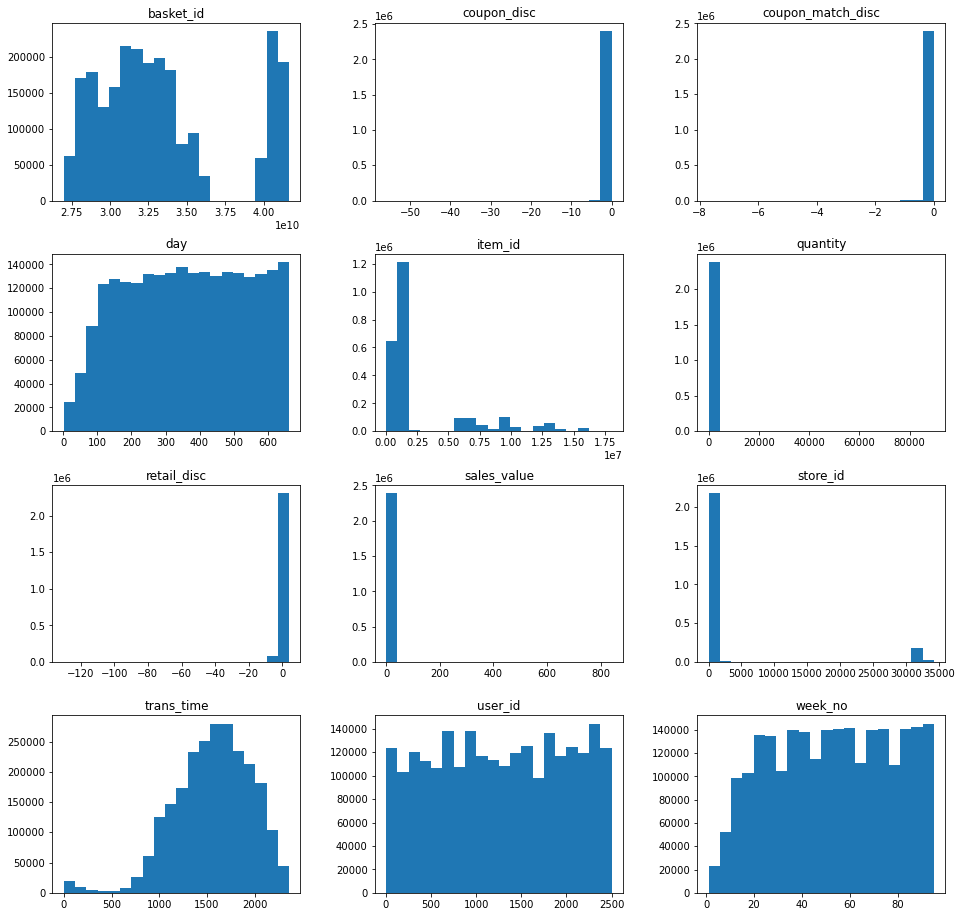

In [14]:
data.hist(figsize=(16,16), bins=20, grid=False);
# есть какая то зависимость от недели - наверное в середине месяца продажи проседают

In [15]:
data.corr()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
user_id,1.000000,-0.001786,0.001185,0.003625,0.000509,0.005177,0.003135,-0.002395,-0.011555,0.001189,-0.001348,-0.000396
basket_id,-0.001786,1.000000,0.951656,0.115241,0.005366,0.012076,0.056067,0.003057,-0.017984,0.951563,-0.008684,-0.008083
day,0.001185,0.951656,1.000000,0.119257,0.006452,0.013228,0.053649,0.001865,-0.016372,0.999931,-0.009720,-0.007487
item_id,0.003625,0.115241,0.119257,1.000000,0.083010,0.129376,0.013842,-0.051883,0.002238,0.119272,-0.043568,-0.016706
quantity,0.000509,0.005366,0.006452,0.083010,1.000000,0.588051,-0.013086,-0.038437,-0.021571,0.006557,0.006494,0.006252
sales_value,0.005177,0.012076,0.013228,0.129376,0.588051,1.000000,-0.002470,-0.250784,-0.017022,0.013203,-0.039580,0.003256
store_id,0.003135,0.056067,0.053649,0.013842,-0.013086,-0.002470,1.000000,0.004348,-0.004520,0.053558,-0.000031,0.001750
retail_disc,-0.002395,0.003057,0.001865,-0.051883,-0.038437,-0.250784,0.004348,1.000000,0.004672,0.001866,0.047947,0.013991
trans_time,-0.011555,-0.017984,-0.016372,0.002238,-0.021571,-0.017022,-0.004520,0.004672,1.000000,-0.015654,0.003389,0.006249
week_no,0.001189,0.951563,0.999931,0.119272,0.006557,0.013203,0.053558,0.001866,-0.015654,1.000000,-0.009686,-0.007440


2. Подготовка и тестирование модели

In [16]:
# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [17]:
# Подготовим двухуровневую модель

Отфильтруем товары в соответствии со следующими ограничениями:

1. Нельзя рекомендовать top 3 самых популярных товаров
2. Нельзя рекомендовать товары, которые не продавались последние 12 месяцев
3. Нельзя рекомендовать товары, с общим числом продаж < 50
4. Нельзя рекомендовать товары, которые стоят < 1$

In [18]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
popularity = popularity.sort_values('n_sold', ascending=False)
popularity = popularity.drop(popularity[(popularity['n_sold'] < 50)].index)
popularity_list = popularity.item_id.tolist()
popularity_list = popularity_list[3:]

popularity

,item_id,n_sold
55470,6534178,190227964
55430,6533889,15978434
55465,6534166,12439291
55576,6544236,2501949
43620,1404121,1562004
...,...,...
12393,880333,50
12084,877391,50
25224,996679,50
26817,1010870,50


In [19]:
time = data_train.groupby('item_id')['week_no'].max().reset_index()
time = time.sort_values('week_no', ascending=False)
time = time.drop(time[(time['week_no'] < 52)].index)
time_list = time.item_id.tolist()

time

,item_id,week_no
86864,17829232,91
21524,962185,91
21510,962012,91
21508,961998,91
21505,961991,91
...,...,...
57720,7029820,52
47919,2054623,52
71498,10457075,52
60506,8086244,52


In [20]:
cost = data_train.groupby('item_id')['sales_value'].max().reset_index()
cost = cost.sort_values('sales_value', ascending=False)
cost = cost.drop(cost[(cost['sales_value'] < 1)].index)
cost_list = cost.item_id.tolist()

cost

,item_id,sales_value
74422,12484608,840.00
20045,948670,631.80
35444,1089093,505.00
79423,13212959,499.99
80477,13506935,329.99
...,...,...
2171,115416,1.00
69016,10119578,1.00
46445,1863068,1.00
43614,1403622,1.00


In [21]:
item_id_list = []

for i in popularity_list:
    if i in cost_list:
        if i in time_list:
            item_id_list.append(i)

len(item_id_list)

10572

In [22]:
data_train.loc[~data_train['item_id'].isin(item_id_list), 'item_id'] = None
data_train = data_train.dropna()

data_test.loc[~data_test['item_id'].isin(item_id_list), 'item_id'] = None
data_test = data_test.dropna()

/Users/ekaterinarazdumina/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
# Подготовим таблицу для замера результата

In [24]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867.0, 834484.0, 856942.0, 865456.0, 88924..."
1,3,"[835476.0, 851057.0, 872021.0, 878302.0, 87994..."


In [25]:
# Подготовим первый уровень - ALS систему

In [26]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,34873.0,43871.0,51716.0,117847.0,201704.0,202291.0,279994.0,397896.0,420647.0,480014.0,...,15972115.0,15972298.0,15972565.0,15972790.0,16058791.0,16100266.0,16729415.0,16809431.0,16809471.0,17105257.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [28]:
%%time

model = AlternatingLeastSquares(factors=50, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  
          show_progress=True)


CPU times: user 10.2 s, sys: 755 ms, total: 10.9 s
Wall time: 6.74 s


In [29]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [30]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 55.1 s, sys: 7.31 s, total: 1min 2s
Wall time: 15.8 s


In [31]:
# Подготовим второй уровень уровень - LGBboost: добавим признаки для обучения и построим модель 

In [32]:
users_lvl_2 = pd.DataFrame(data_train['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: get_recommendations(x, model=model, N=150))

In [33]:
users_lvl_2_val = pd.DataFrame(data_test['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: get_recommendations(x, model=model, N=150))

In [34]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [35]:
df_val=pd.DataFrame({'user_id':users_lvl_2_val.user_id.values.repeat(len(users_lvl_2_val.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2_val.candidates.values)})

In [36]:
targets_lvl_2 = data_train[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [37]:
targets_lvl_2_val = data_test[['user_id', 'item_id']].copy()
targets_lvl_2_val['target'] = 1  # тут только покупки 

targets_lvl_2_val = df_val.merge(targets_lvl_2_val, on=['user_id', 'item_id'], how='left')

targets_lvl_2_val['target'].fillna(0, inplace= True)

In [38]:
targets_lvl_2.head(10)

,user_id,item_id,target
0,2375,1082185.0,1.0
1,2375,1082185.0,1.0
2,2375,1082185.0,1.0
3,2375,1029743.0,0.0
4,2375,981760.0,1.0
5,2375,981760.0,1.0
6,2375,923746.0,1.0
7,2375,923746.0,1.0
8,2375,923746.0,1.0
9,2375,923746.0,1.0


In [39]:
average_check = data.groupby('user_id')['sales_value'].sum()/(data.groupby('user_id')['sales_value'].count())
average_check = pd.DataFrame(data=average_check)

frequency = data.groupby('user_id')['sales_value'].count() / ((data.groupby('user_id')['week_no'].max() - data.groupby('user_id')['week_no'].min()))
frequency = pd.DataFrame(data=frequency)

item_value = data.groupby('item_id')['sales_value'].sum()/data.groupby('item_id')['sales_value'].count()
item_value = pd.DataFrame(data=item_value)

In [40]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(frequency, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(item_value, on='item_id', how='left')

In [41]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,sales_value_x,0,sales_value_y
0,2375,1082185.0,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.784505,6.989362,0.997406
1,2375,1082185.0,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.784505,6.989362,0.997406


In [42]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_features, on='item_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(user_features, on='user_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(average_check, on='user_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(frequency, on='user_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(item_value, on='item_id', how='left')

targets_lvl_2_val.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,sales_value_x,0,sales_value_y
0,338,845208.0,0.0,69,PRODUCE,Private,ONIONS,ONIONS YELLOW (BULK&BAG),3 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.491748,12.555556,1.984691
1,338,1037863.0,1.0,2,PRODUCE,National,VEGETABLES - ALL OTHERS,CABBAGE,14-18 CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.491748,12.555556,1.397349


In [43]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

X_test = targets_lvl_2_val.drop('target', axis=1)

In [44]:
cat_feats = X_train.columns[2:].tolist()

X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [45]:
model_lgb = lgb.LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)

In [46]:
model_lgb.fit(
    X=X_train, y=y_train)

y_score = model_lgb.predict(X_test)

/Users/ekaterinarazdumina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/ekaterinarazdumina/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [47]:
X_test['result'] = y_score

In [48]:
result_val_2 = X_test[['user_id', 'item_id', 'result']]
result_val_2 = result_val_2.loc[result_val_2['result'] == 1]
result_val_2 = result_val_2.groupby('user_id')['item_id'].apply(list).to_frame()

result_val_2

,item_id
user_id,
1,"[862349.0, 1051211.0, 995242.0, 995242.0, 5569..."
3,"[5569230.0, 1106523.0, 951590.0, 883404.0, 109..."
6,"[878996.0, 1024306.0, 986912.0, 1007195.0, 854..."
7,"[1082185.0, 1082185.0, 1082185.0, 995242.0, 98..."
8,"[883404.0, 938700.0, 1053690.0, 1068719.0, 844..."
...,...
2494,"[1082185.0, 1029743.0, 995242.0, 1127831.0, 98..."
2497,"[5569471.0, 5569230.0, 5569230.0, 951590.0, 55..."
2498,"[1082185.0, 1029743.0, 995242.0, 1053690.0, 10..."


In [49]:
result = result.merge(result_val_2, on='user_id', how='left')
result.rename(columns={'item_id': 'lvl2_raw'}, inplace=True)

3. Постфильтр данных и применение последнего бизнес-ограничения

In [50]:
bought = data_train.groupby('user_id')['item_id'].unique().reset_index()
bought.columns=['user_id', 'bought']
result = result.merge(bought, on='user_id', how='left')

In [51]:
pop_items = list(item_id_list[:50])

In [52]:
def ad_pop_items(user):
    recs = result.loc[result['user_id'] == user, 'lvl2_raw'].tolist()
    ad_items = item_id_list[:50]
    
    recs_fin = []
    
    try:
        for i in range(len(recs[0])):
            recs_fin.append(recs[0][i])
    
    except:
        pass
    
    for i in range(50):
        recs_fin.append(ad_items[i])
        
    return recs_fin
        

In [53]:
result['lvl2_pf'] = result['user_id'].apply(lambda x: ad_pop_items(x))

In [54]:
def get_out_bought(user):
    recs = result.loc[result['user_id'] == user, 'lvl2_pf'].tolist()
    user_bought = list(bought.loc[bought['user_id'] == user, 'bought'])
    
    for rec in recs[0]:
        if rec in user_bought[0]:
            recs[0].remove(rec)
            
    return recs

In [55]:
result['fin'] = result['user_id'].apply(lambda x: get_out_bought(x))

In [56]:
result

,user_id,actual,als,lvl2_raw,bought,lvl2_pf,fin
0,1,"[821867.0, 834484.0, 856942.0, 865456.0, 88924...","[862349.0, 1051211.0, 995242.0, 5569374.0, 102...","[862349.0, 1051211.0, 995242.0, 995242.0, 5569...","[825123.0, 840361.0, 845307.0, 852014.0, 85694...","[862349.0, 1051211.0, 885290.0, 1005186.0, 107...","[[862349.0, 1051211.0, 885290.0, 1005186.0, 10..."
1,3,"[835476.0, 851057.0, 872021.0, 878302.0, 87994...","[5569230.0, 1106523.0, 951590.0, 883404.0, 109...","[5569230.0, 1106523.0, 951590.0, 883404.0, 109...","[866211.0, 878996.0, 882830.0, 904360.0, 92134...","[1106523.0, 5568378.0, 910032.0, 1029743.0, 96...","[[1106523.0, 5568378.0, 910032.0, 1029743.0, 9..."
2,6,"[920308.0, 926804.0, 946489.0, 1017061.0, 1078...","[878996.0, 1024306.0, 986912.0, 1007195.0, 854...","[878996.0, 1024306.0, 986912.0, 1007195.0, 854...","[840361.0, 851819.0, 851903.0, 863447.0, 87623...","[1024306.0, 854852.0, 860776.0, 1023720.0, 102...","[[1024306.0, 854852.0, 860776.0, 1023720.0, 10..."
3,7,"[840386.0, 889774.0, 898068.0, 909714.0, 95347...","[1082185.0, 995242.0, 981760.0, 1029743.0, 110...","[1082185.0, 1082185.0, 1082185.0, 995242.0, 98...","[865569.0, 886703.0, 889731.0, 893400.0, 10220...","[981760.0, 840361.0, 883404.0, 1122358.0, 1122...","[[981760.0, 840361.0, 883404.0, 1122358.0, 112..."
4,8,"[835098.0, 872137.0, 910439.0, 924610.0, 99297...","[883404.0, 938700.0, 1053690.0, 1068719.0, 844...","[883404.0, 938700.0, 1053690.0, 1068719.0, 844...","[824555.0, 835576.0, 841220.0, 847982.0, 84984...","[938700.0, 1068719.0, 1053763.0, 923746.0, 100...","[[938700.0, 1068719.0, 1053763.0, 923746.0, 10..."
...,...,...,...,...,...,...,...
1979,2494,"[859075.0, 1071939.0, 5568729.0]","[1082185.0, 1029743.0, 995242.0, 1127831.0, 98...","[1082185.0, 1029743.0, 995242.0, 1127831.0, 98...","[825550.0, 825650.0, 849843.0, 861272.0, 87061...","[995242.0, 981760.0, 961554.0, 860776.0, 84036...","[[995242.0, 981760.0, 961554.0, 860776.0, 8403..."
1980,2497,"[1016709.0, 9835695.0, 845294.0, 871756.0, 873...","[5569471.0, 5569230.0, 951590.0, 5569845.0, 99...","[5569471.0, 5569230.0, 5569230.0, 951590.0, 55...","[1037840.0, 1052294.0, 5569230.0, 8090537.0, 1...","[5569230.0, 854852.0, 834484.0, 1081177.0, 105...","[[5569230.0, 854852.0, 834484.0, 1081177.0, 10..."
1981,2498,"[834484.0, 901776.0, 914190.0, 958382.0, 97243...","[1082185.0, 1029743.0, 995242.0, 1053690.0, 10...","[1082185.0, 1029743.0, 995242.0, 1053690.0, 10...","[824555.0, 835576.0, 901776.0, 904023.0, 91121...","[995242.0, 1098066.0, 981760.0, 859075.0, 9043...","[[995242.0, 1098066.0, 981760.0, 859075.0, 904..."
1982,2499,"[867188.0, 902396.0, 914190.0, 951590.0, 95813...","[883404.0, 951590.0, 1098066.0, 826249.0, 1029...","[883404.0, 951590.0, 1098066.0, 826249.0, 1029...","[838186.0, 864143.0, 883665.0, 932949.0, 93383...","[951590.0, 1029743.0, 5569230.0, 1065593.0, 10...","[[951590.0, 1029743.0, 5569230.0, 1065593.0, 1..."


4. Замерим качество на получившейся выборке

In [57]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [58]:
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

0.19778225806451363

In [59]:
result.apply(lambda row: precision_at_k(row['lvl2_raw'], row['actual']), axis=1).mean()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [60]:
result.apply(lambda row: precision_at_k(row['fin'], row['actual']), axis=1).mean()

6.158770161290323